In [6]:
#%matplotlib widget
import scipy
from scipy.special import iv
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from tqdm import trange
from datetime import date
import functools

In [7]:
dTE = 8
n_elements = 128
TDATA = np.arange(0, (n_elements+1)*dTE, dTE)

c1=0.3
c2=0.7
T21=45
T22=100
true_params = [c1, c2, T21, T22]

SNR=150
sigma=(c1+c2)/SNR
noise_floor=np.sqrt(np.pi/2)*sigma

iterations = 1000

ParamLabel = [r'$c_1$', r'$c_2$', r'$T_{21}$', r'$T_{22}$']

In [8]:
def G_biX_off(t, con_1, con_2, tau_1, tau_2, offSet): 
    signal = con_1*np.exp(-t/tau_1) + con_2*np.exp(-t/tau_2) + offSet
    return signal

def G_biX(t, con_1, con_2, tau_1, tau_2): 
    function = con_1*np.exp(-t/tau_1) + con_2*np.exp(-t/tau_2)
    return function

def expRice(tvect,c1,c2,T21,T22):
    alpha=(G_biX(tvect, c1, c2, T21, T22)/(2*sigma))**2
    Expectation = sigma*np.sqrt(np.pi/2)*((1+2*alpha)*scipy.special.ive(0, alpha) + 2*alpha*scipy.special.ive(1,alpha))
    return Expectation

def correc_McGibney(tvect,c1,c2,T21,T22):
    paramFit = G_biX(tvect, c1, c2, T21, T22)
    noise_offset = 2*sigma**2
    return paramFit + noise_offset


def add_rician_noise(data, sigma):
    noise_real=np.random.normal(loc=0.0, scale=sigma, size=len(TDATA))
    noise_imag=np.random.normal(loc=0.0, scale=sigma, size=len(TDATA))

    noisy_sig_channel = data + noise_real
    noisy_quadrature_channel = noise_imag

    riceData = np.sqrt(noisy_sig_channel**2 + noisy_quadrature_channel**2)
    return riceData

def check_param_order(popt):
    #Reshaping of array to ensure that the parameter pairs all end up in the appropriate place - ensures that T22 > T21
    if (popt[-1] < popt[-2]): #We want by convention to make sure that T21 is <= T22
        for pi in range(np.size(popt)//2):
            p_hold = popt[2*pi]
            popt[2*pi] = popt[2*pi+1]
            popt[2*pi+1] = p_hold
    return popt

In [9]:
data = G_biX(TDATA,*true_params)

In [11]:
rician_params = []
mcG_params = []
gud_params = []
offset_params = []
standard_params = []

rician_RSS = []
mcG_RSS = []
gud_RSS = []
offset_RSS = []
standard_RSS = []

for i in trange(iterations):    
    rician_data = add_rician_noise(data, sigma)

    G_biX_params_rice, _, info, _, _ = curve_fit(expRice, TDATA, rician_data, p0=[0.4,0.6,40,80], full_output = True, maxfev = 4000)
    rician_params.append(check_param_order(G_biX_params_rice))
    rician_RSS.append(np.sum(info['fvec']**2))

    G_biX_params_gud, _, info, _, _ = curve_fit(G_biX, TDATA, np.abs(rician_data**2 - sigma**2)**(1/2), p0=[0.4,0.6,40,80], full_output = True, maxfev = 4000)
    gud_params.append(check_param_order(G_biX_params_gud))
    gud_RSS.append(np.sum(info['fvec']**2))

    G_biX_params_mcG, _, info, _, _ = curve_fit(correc_McGibney, TDATA, rician_data, p0=[0.4,0.6,40,80], full_output = True, maxfev = 4000)
    mcG_params.append(check_param_order(G_biX_params_mcG))
    mcG_RSS.append(np.sum(info['fvec']**2))

    G_biX_off_params, _, off_info, _, _ = curve_fit(G_biX_off, TDATA, rician_data, p0=[0.4,0.6,40,80,0.1], full_output = True, maxfev = 4000)
    params_hold = check_param_order(G_biX_off_params[0:-1])
    offset_params.append([*params_hold, G_biX_off_params[-1]])
    offset_RSS.append(np.sum(off_info['fvec']**2))

    G_biX_params, _, info, _, _ = curve_fit(G_biX, TDATA, rician_data, p0=[0.4,0.6,40,80], full_output = True, maxfev = 4000)
    standard_params.append(check_param_order(G_biX_params))
    standard_RSS.append(np.sum(info['fvec']**2))

  7%|▋         | 69/1000 [00:00<00:11, 84.58it/s] /tmp/ipykernel_2246611/1602108178.py:6: RuntimeWarning: overflow encountered in exp
  function = con_1*np.exp(-t/tau_1) + con_2*np.exp(-t/tau_2)
 44%|████▍     | 443/1000 [00:04<00:06, 89.49it/s]/tmp/ipykernel_2246611/1602108178.py:2: RuntimeWarning: overflow encountered in exp
  signal = con_1*np.exp(-t/tau_1) + con_2*np.exp(-t/tau_2) + offSet
100%|██████████| 1000/1000 [00:11<00:00, 89.04it/s]


In [12]:
rician_params = np.array(rician_params)
offset_params = np.array(offset_params)
standard_params = np.array(standard_params)
gud_params = np.array(gud_params)
mcG_params = np.array(mcG_params)

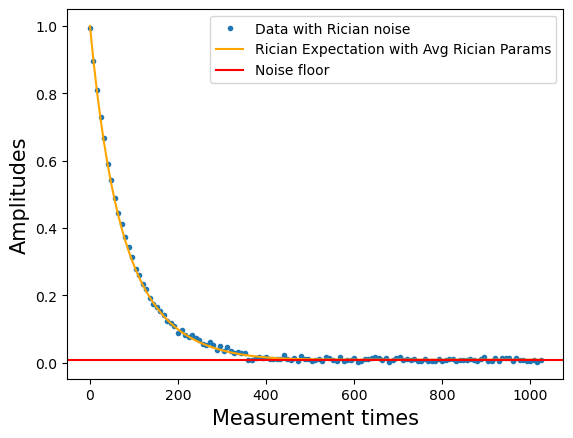

In [14]:
fig = plt.figure()
plt.plot(TDATA, rician_data, "o", markersize=3, label = 'Data with Rician noise')
plt.plot(TDATA, expRice(TDATA, *np.mean(rician_params, axis=0)), color = 'orange', label = 'Rician Expectation with Avg Rician Params')
# plt.plot(TDATA, G_biX(TDATA, *np.mean(rician_params, axis=0)), color = 'green', label = 'Underlying Model with Avg Rician Params')
plt.axhline(y = noise_floor, color = 'r', linestyle = '-', label = 'Noise floor')
plt.xlabel("time")
plt.xlabel("Measurement times", fontsize=15)
plt.ylabel('Amplitudes',fontsize=15)
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


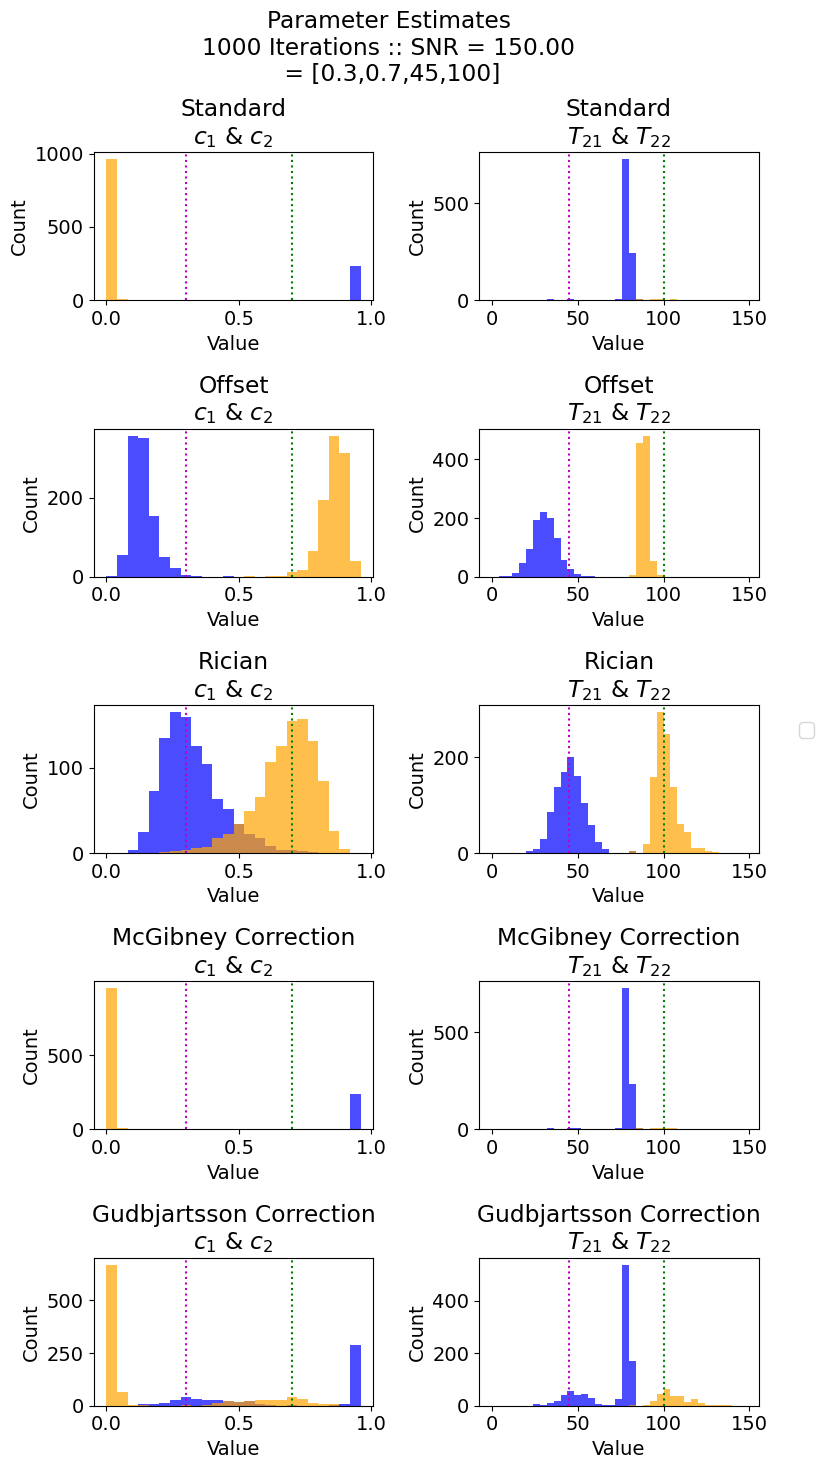

In [15]:
plt.rc('font', size = 14)

fig, ax = plt.subplots(5, 2, figsize=(8, 15), tight_layout=True)
fig.suptitle(f"Parameter Estimates\n{iterations} Iterations :: SNR = {SNR :0.2f}\n = [{c1},{c2},{T21},{T22}]")

#Standard Results
bin_array = np.arange(0, 1, 0.04)
ax[0,0].hist(x=standard_params[:,0], bins=bin_array, color='b', alpha = 0.7)
ax[0,0].hist(x=standard_params[:,1], bins=bin_array, color='orange', alpha = 0.7)
ax[0,0].axvline(x = true_params[0], color='m', ls = ':')
ax[0,0].axvline(x = true_params[1], color='g', ls = ':')
ax[0,0].set_xlabel('Value')
ax[0,0].set_ylabel('Count')
ax[0,0].set_title(f"Standard\n{ParamLabel[0]} & {ParamLabel[1]}")

ymin, ymax = ax[0,0].get_ylim()
xmin, xmax = ax[0,0].get_xlim()
yup = ymin+(ymax-ymin)*2//3
ydn = ymin+(ymax-ymin)*1//3

bin_array = np.arange(0, 150, 4)
ax[0,1].hist(x=standard_params[:,2], bins=bin_array, color='b', alpha = 0.7)
ax[0,1].hist(x=standard_params[:,3], bins=bin_array, color='orange', alpha = 0.7)
ax[0,1].axvline(x = true_params[2], color='m', ls = ':')
ax[0,1].axvline(x = true_params[3], color='g', ls = ':')
ax[0,1].set_xlabel('Value')
ax[0,1].set_ylabel('Count')
ax[0,1].set_title(f"Standard\n{ParamLabel[2]} & {ParamLabel[3]}")

ymin, ymax = ax[0,1].get_ylim()
xmin, xmax = ax[0,1].get_xlim()
yup = ymin+(ymax-ymin)*2//3
ydn = ymin+(ymax-ymin)*1//3

#Offset Result
bin_array = np.arange(0, 1, 0.04)
ax[1,0].hist(x=offset_params[:,0], bins=bin_array, color='b', alpha = 0.7)
ax[1,0].hist(x=offset_params[:,1], bins=bin_array, color='orange', alpha = 0.7)
ax[1,0].axvline(x = true_params[0], color='m', ls = ':')
ax[1,0].axvline(x = true_params[1], color='g', ls = ':')
ax[1,0].set_xlabel('Value')
ax[1,0].set_ylabel('Count')
ax[1,0].set_title(f"Offset\n{ParamLabel[0]} & {ParamLabel[1]}")

ymin, ymax = ax[1,0].get_ylim()
xmin, xmax = ax[1,0].get_xlim()
yup = ymin+(ymax-ymin)*2//3
ydn = ymin+(ymax-ymin)*1//3

bin_array = np.arange(0, 150, 4)
ax[1,1].hist(x=offset_params[:,2], bins=bin_array, color='b', alpha = 0.7)
ax[1,1].hist(x=offset_params[:,3], bins=bin_array, color='orange', alpha = 0.7)
ax[1,1].axvline(x = true_params[2], color='m', ls = ':')
ax[1,1].axvline(x = true_params[3], color='g', ls = ':')
ax[1,1].set_xlabel('Value')
ax[1,1].set_ylabel('Count')
ax[1,1].set_title(f"Offset\n{ParamLabel[2]} & {ParamLabel[3]}")

ymin, ymax = ax[1,1].get_ylim()
xmin, xmax = ax[1,1].get_xlim()
yup = ymin+(ymax-ymin)*2//3
ydn = ymin+(ymax-ymin)*1//3

#Rician Results
bin_array = np.arange(0, 1, 0.04)
ax[2,0].hist(x=rician_params[:,0], bins=bin_array, color='b', alpha = 0.7)
ax[2,0].hist(x=rician_params[:,1], bins=bin_array, color='orange', alpha = 0.7)
ax[2,0].axvline(x = true_params[0], color='m', ls = ':')
ax[2,0].axvline(x = true_params[1], color='g', ls = ':')
ax[2,0].set_xlabel('Value')
ax[2,0].set_ylabel('Count')
ax[2,0].set_title(f"Rician\n{ParamLabel[0]} & {ParamLabel[1]}")

ymin, ymax = ax[2,0].get_ylim()
xmin, xmax = ax[2,0].get_xlim()
yup = ymin+(ymax-ymin)*2//3
ydn = ymin+(ymax-ymin)*1//3

bin_array = np.arange(0, 150, 4)
ax[2,1].hist(x=rician_params[:,2], bins=bin_array, color='b', alpha = 0.7)
ax[2,1].hist(x=rician_params[:,3], bins=bin_array, color='orange', alpha = 0.7)
ax[2,1].axvline(x = true_params[2], color='m', ls = ':')
ax[2,1].axvline(x = true_params[3], color='g', ls = ':')
ax[2,1].set_xlabel('Value')
ax[2,1].set_ylabel('Count')
ax[2,1].set_title(f"Rician\n{ParamLabel[2]} & {ParamLabel[3]}")

ymin, ymax = ax[2,1].get_ylim()
xmin, xmax = ax[2,1].get_xlim()
yup = ymin+(ymax-ymin)*2//3
ydn = ymin+(ymax-ymin)*1//3

#mcG Results
bin_array = np.arange(0, 1, 0.04)
ax[3,0].hist(x=mcG_params[:,0], bins=bin_array, color='b', alpha = 0.7)
ax[3,0].hist(x=mcG_params[:,1], bins=bin_array, color='orange', alpha = 0.7)
ax[3,0].axvline(x = true_params[0], color='m', ls = ':')
ax[3,0].axvline(x = true_params[1], color='g', ls = ':')
ax[3,0].set_xlabel('Value')
ax[3,0].set_ylabel('Count')
ax[3,0].set_title(f"McGibney Correction\n{ParamLabel[0]} & {ParamLabel[1]}")

ymin, ymax = ax[3,0].get_ylim()
xmin, xmax = ax[3,0].get_xlim()
yup = ymin+(ymax-ymin)*2//3
ydn = ymin+(ymax-ymin)*1//3

bin_array = np.arange(0, 150, 4)
ax[3,1].hist(x=mcG_params[:,2], bins=bin_array, color='b', alpha = 0.7)
ax[3,1].hist(x=mcG_params[:,3], bins=bin_array, color='orange', alpha = 0.7)
ax[3,1].axvline(x = true_params[2], color='m', ls = ':')
ax[3,1].axvline(x = true_params[3], color='g', ls = ':')
ax[3,1].set_xlabel('Value')
ax[3,1].set_ylabel('Count')
ax[3,1].set_title(f"McGibney Correction\n{ParamLabel[2]} & {ParamLabel[3]}")

ymin, ymax = ax[3,1].get_ylim()
xmin, xmax = ax[3,1].get_xlim()
yup = ymin+(ymax-ymin)*2//3
ydn = ymin+(ymax-ymin)*1//3

#Gud Results
bin_array = np.arange(0, 1, 0.04)
ax[4,0].hist(x=gud_params[:,0], bins=bin_array, color='b', alpha = 0.7)
ax[4,0].hist(x=gud_params[:,1], bins=bin_array, color='orange', alpha = 0.7)
ax[4,0].axvline(x = true_params[0], color='m', ls = ':')
ax[4,0].axvline(x = true_params[1], color='g', ls = ':')
ax[4,0].set_xlabel('Value')
ax[4,0].set_ylabel('Count')
ax[4,0].set_title(f"Gudbjartsson Correction\n{ParamLabel[0]} & {ParamLabel[1]}")

ymin, ymax = ax[4,0].get_ylim()
xmin, xmax = ax[4,0].get_xlim()
yup = ymin+(ymax-ymin)*2//3
ydn = ymin+(ymax-ymin)*1//3

bin_array = np.arange(0, 150, 4)
ax[4,1].hist(x=gud_params[:,2], bins=bin_array, color='b', alpha = 0.7)
ax[4,1].hist(x=gud_params[:,3], bins=bin_array, color='orange', alpha = 0.7)
ax[4,1].axvline(x = true_params[2], color='m', ls = ':')
ax[4,1].axvline(x = true_params[3], color='g', ls = ':')
ax[4,1].set_xlabel('Value')
ax[4,1].set_ylabel('Count')
ax[4,1].set_title(f"Gudbjartsson Correction\n{ParamLabel[2]} & {ParamLabel[3]}")

ymin, ymax = ax[4,1].get_ylim()
xmin, xmax = ax[4,1].get_xlim()
yup = ymin+(ymax-ymin)*2//3
ydn = ymin+(ymax-ymin)*1//3

fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Text(0.5, 1.0, 'McGibley')

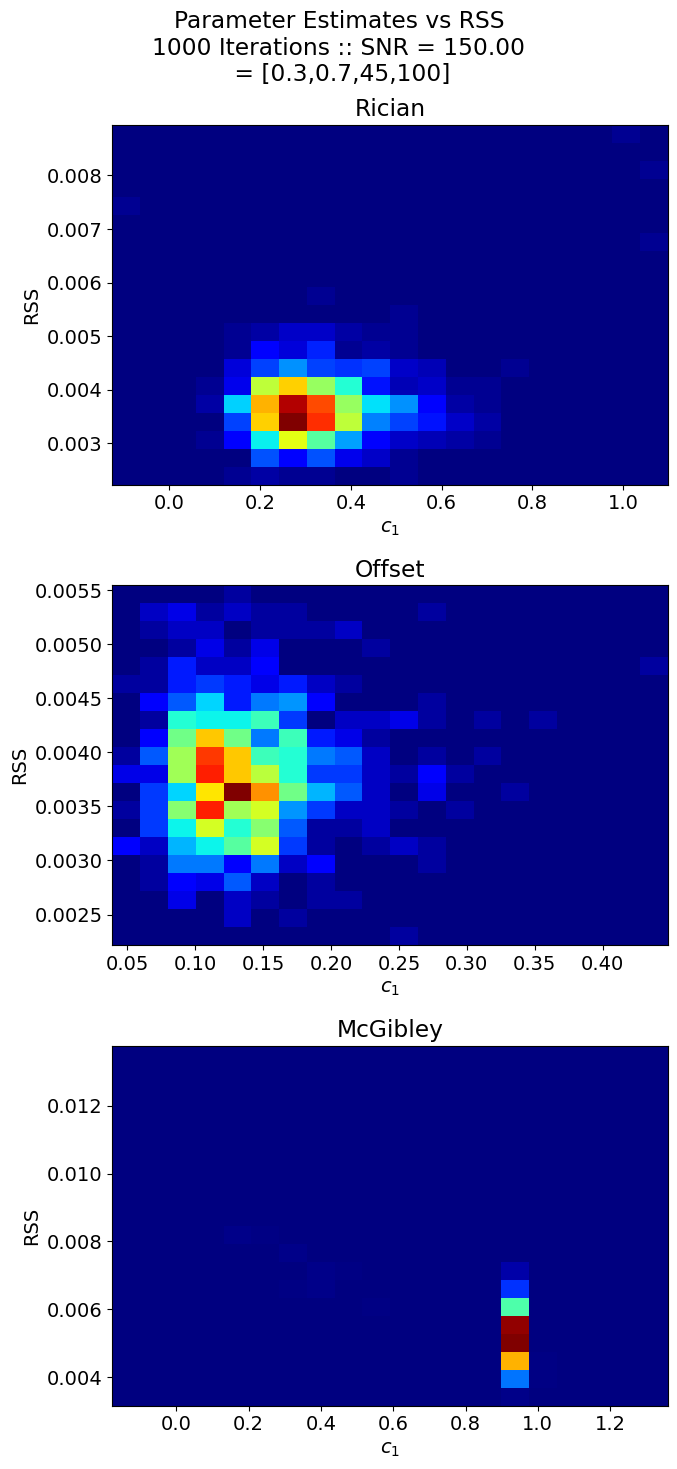

In [16]:
plt.rc('font', size = 14)

fig, ax = plt.subplots(3, 1, figsize=(7, 15), tight_layout=True)
fig.suptitle(f"Parameter Estimates vs RSS\n{iterations} Iterations :: SNR = {SNR :0.2f}\n = [{c1},{c2},{T21},{T22}]")

ax[0].hist2d(rician_params[:,0], rician_RSS, bins = (20,20), cmap = plt.cm.jet)
ax[0].set_xlabel(f'{ParamLabel[0]}')
ax[0].set_ylabel(f'RSS')
ax[0].set_title('Rician')

ax[1].hist2d(offset_params[:,0], offset_RSS, bins = (20,20), cmap = plt.cm.jet)
ax[1].set_xlabel(f'{ParamLabel[0]}')
ax[1].set_ylabel(f'RSS')
ax[1].set_title('Offset')

ax[2].hist2d(mcG_params[:,0], mcG_RSS, bins = (20,20), cmap = plt.cm.jet)
ax[2].set_xlabel(f'{ParamLabel[0]}')
ax[2].set_ylabel(f'RSS')
ax[2].set_title('McGibley')